### 3.1

In the context of the Madaline neural network, MRI (Madaline Rule I) and MRII (Madaline Rule II) are key training algorithms that are specially designed for networks that use ADALINE (Adaptive Linear Neuron) units. Unlike backpropagation, which relies on differentiable activation functions, these rules cater to the non-differentiable step function used in ADALINE units, making them better suited for training layered networks with threshold-based logic.

1. **MRI (Madaline Rule I)**: This rule was the initial method developed to adjust weights in Madaline networks. MRI operates on a single-layer network, where it iteratively adjusts the weights to minimize output errors based on a fixed threshold criterion. This approach was effective for linearly separable problems but limited for more complex patterns, as it relies on simple error correction through thresholding.

2. **MRII (Madaline Rule II)**: MRII expanded the training capability to multi-layer Madaline networks, applying a “minimal disturbance” principle to make incremental changes only when necessary. When an output error is detected, MRII performs "trial adaptations" by adjusting the outputs of individual ADALINEs in the first layer based on their confidence levels. If these individual adjustments don’t correct the error, MRII escalates to combinations of multiple ADALINE units (e.g., pairs or triples), adjusting until the output error is minimized. This algorithm allows Madaline networks to generalize better and handle more complex, non-linear patterns by strategically tuning multiple units across layers, thereby enabling broader applications in pattern recognition tasks.

### 3.2

In [318]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [117]:
data = pd.read_csv('./data/Question3.csv', header=None)
data

,0,1,2
0,0.459694,-0.470583,0.0
1,0.797385,-0.343030,0.0
2,0.235270,0.961296,0.0
3,0.765453,-0.177644,0.0
4,-0.335577,-0.313893,0.0
...,...,...,...
195,0.744066,-1.206548,1.0
196,-0.457547,1.286227,1.0
197,-1.020000,-0.783926,1.0
198,1.363429,-0.800250,1.0


In [350]:
class Utils:
    @staticmethod
    def create_mesh_grid(x, resolution):
        padding = 1
        x1_min, x1_max = x[:, 0].min() - padding, x[:, 0].max() + padding
        x2_min, x2_max = x[:, 1].min() - padding, x[:, 1].max() + padding
        xx1, xx2 = np.meshgrid(
            np.arange(x1_min, x1_max, resolution),
            np.arange(x2_min, x2_max, resolution)
        )
        return xx1, xx2, x1_min, x1_max, x2_min, x2_max
    
    @staticmethod
    def create_mesh_grid(x, resolution):
        padding = 1
        x1_min, x1_max = x[:, 0].min() - padding, x[:, 0].max() + padding
        x2_min, x2_max = x[:, 1].min() - padding, x[:, 1].max() + padding
        xx1, xx2 = np.meshgrid(
            np.arange(x1_min, x1_max, resolution),
            np.arange(x2_min, x2_max, resolution)
        )
        return xx1, xx2, x1_min, x1_max, x2_min, x2_max
    
    @staticmethod
    def plot_neuron_lines(classifier):
        for i in range(classifier.n_neurons):
            intercept = float(-classifier.bias[i] / classifier.weights[i][1])
            slope = -classifier.weights[i][0] / classifier.weights[i][1]
            plt.axline((0, intercept), slope=slope, color="purple", alpha=0.5, 
                      linestyle='--', label=f'Neuron {i+1}' if i == 0 else "")
    
    @staticmethod
    def plot_scatter_points(x, y, cmap, markers):
        for idx, label in enumerate(np.unique(y)):
            mask = y == label
            plt.scatter(
                x=x[mask, 0],
                y=x[mask, 1],
                alpha=0.8,
                c=[cmap(idx)],
                marker=markers[idx],
                label=f'Class {int(label)}',
                edgecolor='black',
                s=100
            )
            
    @staticmethod
    def plot_decision_regions_madaline(x, y, classifier, resolution=0.02):

        plt.figure(figsize=(8, 5))
        colors = ["lightblue", "salmon"]
        markers = ("o", "^")
        cmap = ListedColormap(colors)
        
        xx1, xx2, x1_min, x1_max, x2_min, x2_max = Utils.create_mesh_grid(x, resolution)
        
        mesh_points = np.array([xx1.ravel(), xx2.ravel()]).T
        z = classifier.predict(mesh_points)
        z = z.reshape(xx1.shape)
        
        plt.contourf(xx1, xx2, z, alpha=0.3, cmap=cmap)
        Utils.plot_neuron_lines(classifier)
        Utils.plot_scatter_points(x, y, cmap, markers)
        
        plt.xlim(x1_min, x1_max)
        plt.ylim(x2_min, x2_max)
        plt.xlabel("Feature 1", fontsize=12)
        plt.ylabel("Feature 2", fontsize=12)
        plt.legend(loc="upper left", fontsize=10)
        plt.title("Madaline Decision Regions", fontsize=14)
        plt.grid(True, alpha=0.15)
        
        plt.show()

    @staticmethod
    def plot_data_scatter_plot(x, y):
        colors = ["lightblue", "salmon"]
        markers = ("o", "^")
        cmap = ListedColormap(colors)
        Utils.plot_scatter_points(x, y, cmap, markers)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.title("Scatter Plot of the Data")
        plt.legend(loc='upper left')
        plt.show()

    @staticmethod
    def plot_errors(errors, title: str):
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(errors) + 1), errors)
        plt.xlabel("Epochs")
        plt.ylabel("Sum-squared-error")
        plt.title(title)
        plt.show()

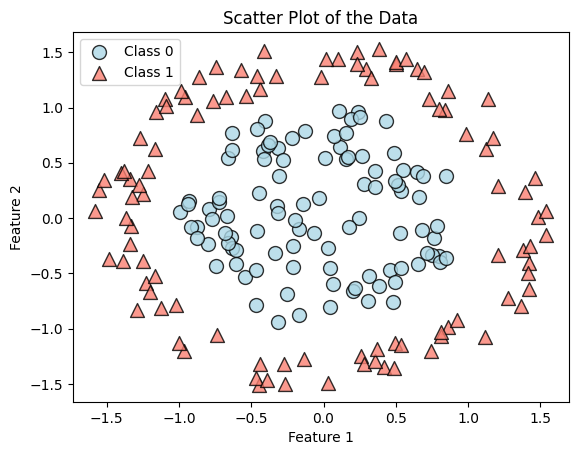

In [351]:
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]
X, Y = np.array(X), np.array(Y)

Utils.plot_data_scatter_plot(X, Y)

### 3.3

In [304]:
class Madaline:
    def __init__(self, n_neurons, lr, epochs):
        self.n_neurons = n_neurons
        self.lr = lr
        self.epochs = epochs

        self.bias = np.zeros(self.n_neurons) + 0.01
        self.output_layer_weights = np.zeros(self.n_neurons) + 1
        self.output_layer_bias = n_neurons - 1

    def activation_fn(self, x):
        return np.where(x >= 0.0, 1, -1)
    
    def loss(self, label, y_pred):
        return np.power((label - y_pred), 2) / 2.0

    def forward(self, x):
        z_input = np.sum(x * self.weights, axis=1) + self.bias
        z = np.array([self.activation_fn(x) for x in z_input])

        y_input = np.dot(z, self.output_layer_weights) + self.output_layer_bias
        y_pred = self.activation_fn(y_input)
        return z_input, y_pred
    
    def update_weights(self, x, z_input, y_pred, label):
        if y_pred == label:
            return
        
        if label == 1.0:
            # For positive labels, update the neuron with maximum activation
            max_activation_idx = z_input.argmax()
            target = 1.0
            mask = np.zeros_like(z_input, dtype=bool)
            mask[max_activation_idx] = True
        else:
            # For negative labels, update all neurons with positive activation
            mask = z_input > 0
            target = -1.0
 
        errors = target - z_input[mask]
        x_broadcast = x.reshape(1, -1) if mask.sum() > 1 else x
    
        self.weights[mask] += self.lr * errors.reshape(-1, 1) * x_broadcast
        self.bias[mask] += self.lr * errors
        

    def fit(self, X, Y):
        self.weights = np.zeros(shape = (self.n_neurons, X.shape[1])) + 0.01

        self.cost_per_epoch = []
        for epoch in tqdm(range(self.epochs)):
            cost = 0
            for x, label in zip(X, Y):
                z_input, y_pred = self.forward(x)
                cost += self.loss(label, y_pred)
                self.update_weights(x, z_input, y_pred, label)
            
            
            self.cost_per_epoch.append(cost)
    
        return self
    
    def predict(self, X):
        predicted = []
        for x in X:
            z_input, y_pred = self.forward(x) 
            predicted.append(y_pred)

        return np.array(predicted)
                        

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
y_train = np.where(y_train == 1, 1, -1)
y_test = np.where(y_test == 1, 1, -1)

Madaline Model using 3 hidden neurons:


100%|██████████| 100/100 [00:01<00:00, 50.08it/s]


Train Accuracy : 0.90625
Test Accuracy : 0.85
------------


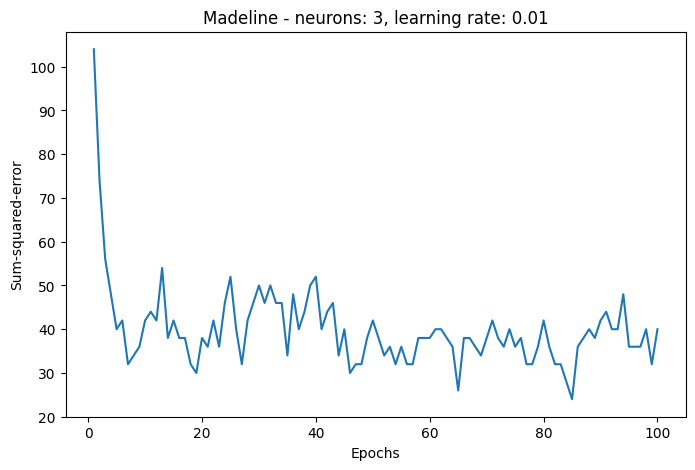

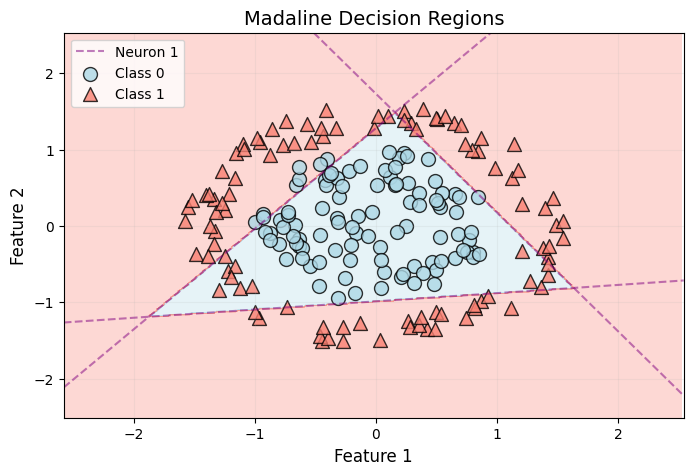

Madaline Model using 4 hidden neurons:


100%|██████████| 100/100 [00:01<00:00, 80.77it/s]


Train Accuracy : 1.0
Test Accuracy : 0.95
------------


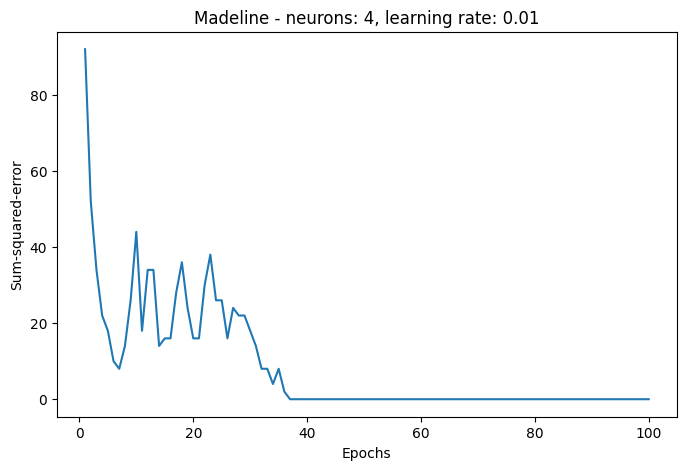

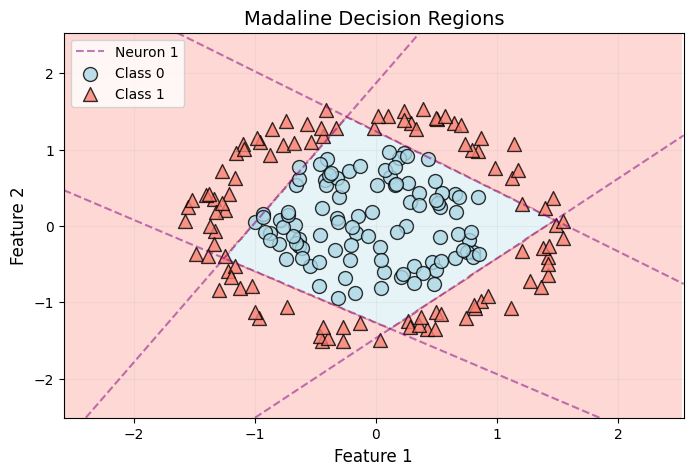

Madaline Model using 8 hidden neurons:


100%|██████████| 100/100 [00:01<00:00, 63.19it/s]


Train Accuracy : 1.0
Test Accuracy : 0.975
------------


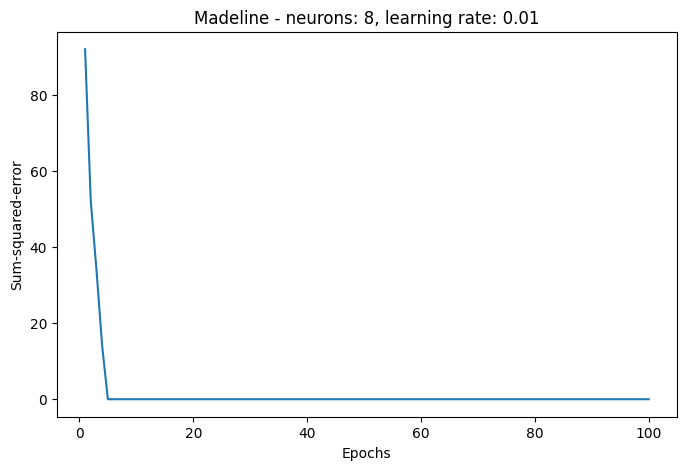

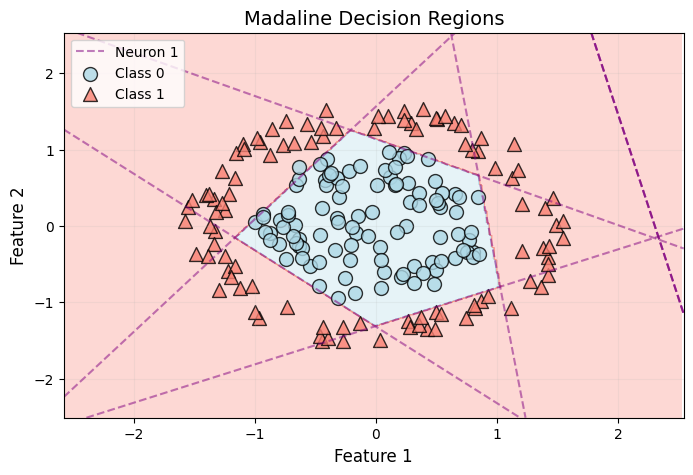

In [352]:
n_neurons = [3, 4, 8]

for n in n_neurons:
    print(f"Madaline Model using {n} hidden neurons:")
    lr = 0.01
    epochs = 100
    model = Madaline(n, lr, epochs)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_train_pred)
    print(f'Train Accuracy : {accuracy}')

    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test Accuracy : {accuracy}\n------------')
    Utils.plot_errors(model.cost_per_epoch, f"Madeline - neurons: {n}, learning rate: {lr}")
    Utils.plot_decision_regions_madaline(X, Y, model)
